In [2]:
import json
import os
import cv2
import numpy as np

from concurrent.futures import ThreadPoolExecutor, as_completed

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow as tf

from model import create_vit_layer

gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data_dir = './data/dfdc_train_part_0'
metadata_path = os.path.join(data_dir, 'metadata.json')
frames_dir  = os.path.join(data_dir, 'frames')
faces_dir = os.path.join(data_dir, 'cropped_faces')

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

In [4]:
# Getting Dataset

def load_frames_from_video(video_dir, num_frames=10, img_size=(224, 224)):
    frames = []
    frame_files = sorted([os.path.join(video_dir, img) for img in os.listdir(video_dir) if img.endswith('.jpg') or img.endswith('.png')])
    
    for img_path in frame_files[:num_frames]:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        frames.append(img)
    
    return tf.stack(frames)

def create_dataset(file_names, labels, base_path, num_frames=10, img_size=(224, 224)):
    def generator():
        for file_name, label in zip(file_names, labels):
            video_dir = os.path.join(base_path, file_name.replace('.mp4', ''))
            if os.path.exists(video_dir):
                frames = load_frames_from_video(video_dir, num_frames, img_size)
                yield frames, label

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(num_frames, *img_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    return dataset

In [5]:
file_names = []
labels = []
for key, value in metadata.items():
    file_names.append(key)
    labels.append(1 if value['label'] == 'FAKE' else 0)

In [7]:
train_dataset = create_dataset(file_names=file_names, labels=labels, base_path=frames_dir)
train_dataset = train_dataset.batch(1)

In [8]:
def create_vit_lstm_model(input_shape, frames, num_classes):
    # Input for video frames (e.g., batch_size, time_steps, height, width, channels)
    video_input = layers.Input(shape=(frames, *input_shape))
    
    # TimeDistributed layer to apply the ViT model to each frame
    vit_layer = create_vit_layer(input_shape)
    processed_frames = layers.TimeDistributed(vit_layer)(video_input)
    
    # LSTM layer to process sequences of extracted features
    lstm_out = layers.LSTM(128, return_sequences=False)(processed_frames)
    
    # Fully connected layer
    dense_out = layers.Dense(64, activation='relu')(lstm_out)
    dense_out = layers.Dropout(0.5)(dense_out)
    
    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(dense_out)
    
    # Define the model
    model = models.Model(inputs=video_input, outputs=output)
    
    return model

Model Created
Model Compiled


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 64)         │       382,144 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,346 (1.87 MB)

 Trainable params: 489,346 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

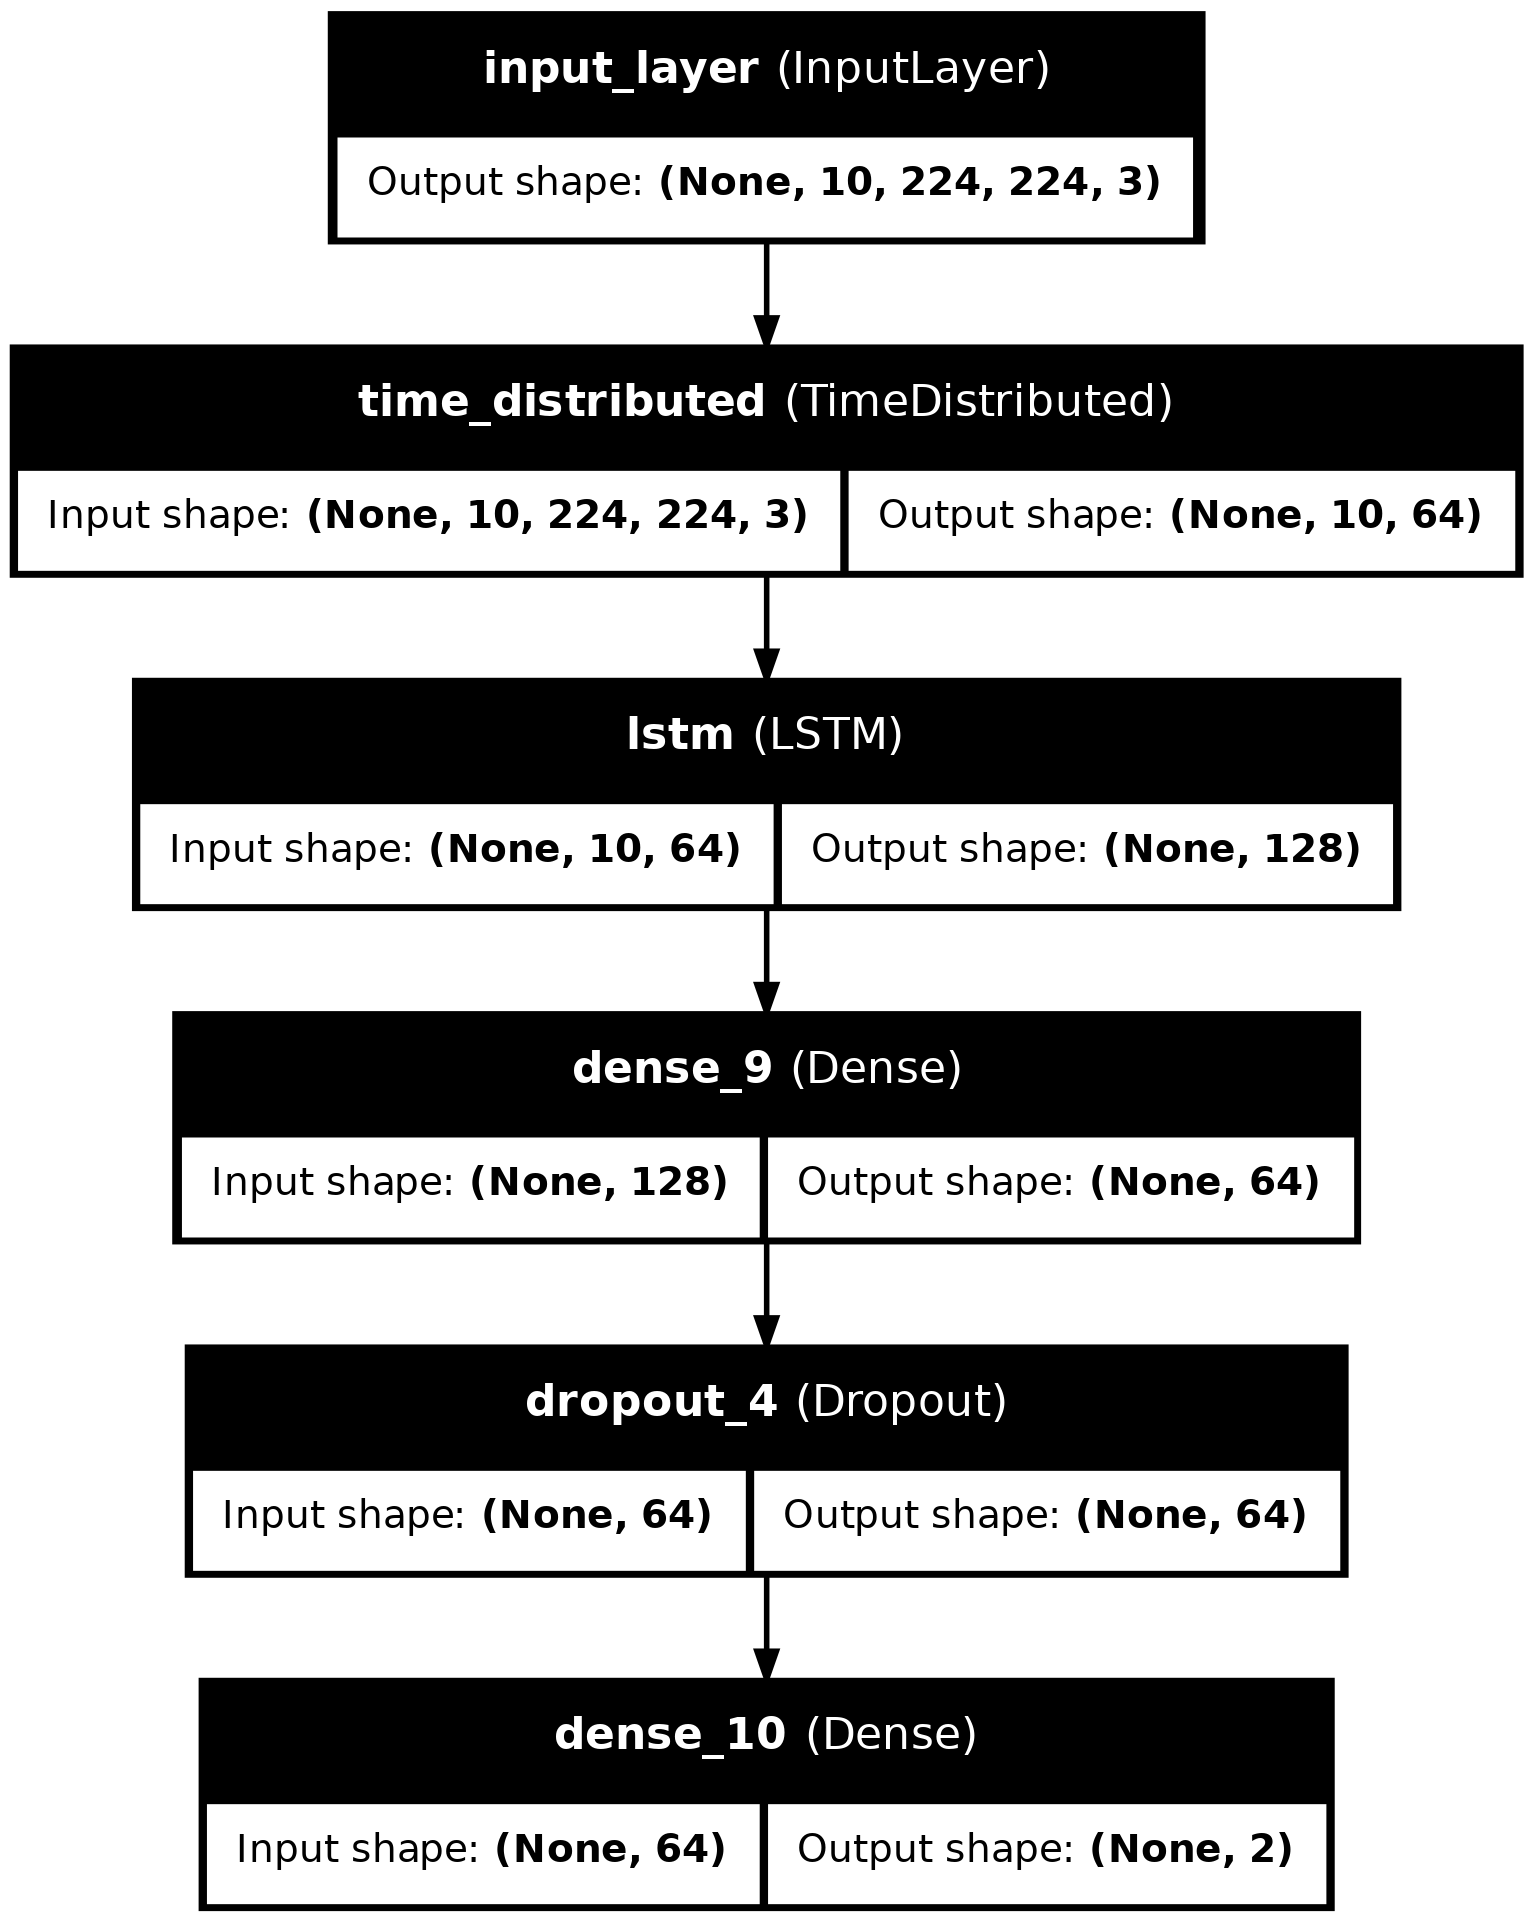

In [9]:
input_shape = (224, 224, 3)
frames = 10
num_classes = 2

model = create_vit_lstm_model(input_shape, frames, num_classes)
print("Model Created")

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print("Model Compiled")


model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
model.fit(train_dataset, epochs=10)
model.save('model_1_vit_lstm')